## CIFAR-10 Dataset Preparation and EDA

In [66]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

meta = unpickle('cifar-10/batches.meta')
label_names = meta[b'label_names']

label_names = [label.decode('utf-8') for label in label_names]
print("Label Names:", label_names)

Label Names: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


### Combine all dataset batches

In [68]:
train_files = [
    'cifar-10/data_batch_1',
    'cifar-10/data_batch_2',
    'cifar-10/data_batch_3',
    'cifar-10/data_batch_4',
    'cifar-10/data_batch_5'
]

train_data = []
train_labels = []

# Load and combine each batch into one dataset
for file in train_files:
    batch = unpickle(file)
    train_data.append(batch[b'data'])
    train_labels.extend(batch[b'labels'])

# Stack all data into a single numpy array and labels into a list
train_data = np.vstack(train_data)
train_labels = np.array(train_labels)
print(f"Combined training data shape: {train_data.shape}")
print(f"Combined training labels shape: {train_labels.shape}")


Combined training data shape: (50000, 3072)
Combined training labels shape: (50000,)


### Load test data batch

In [70]:
test_batch = unpickle('cifar-10/test_batch')
test_data = test_batch[b'data']
test_labels = np.array(test_batch[b'labels'])

print(f"Test data shape: {test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")


Test data shape: (10000, 3072)
Test labels shape: (10000,)


### Reshape Data and Display Sample Images

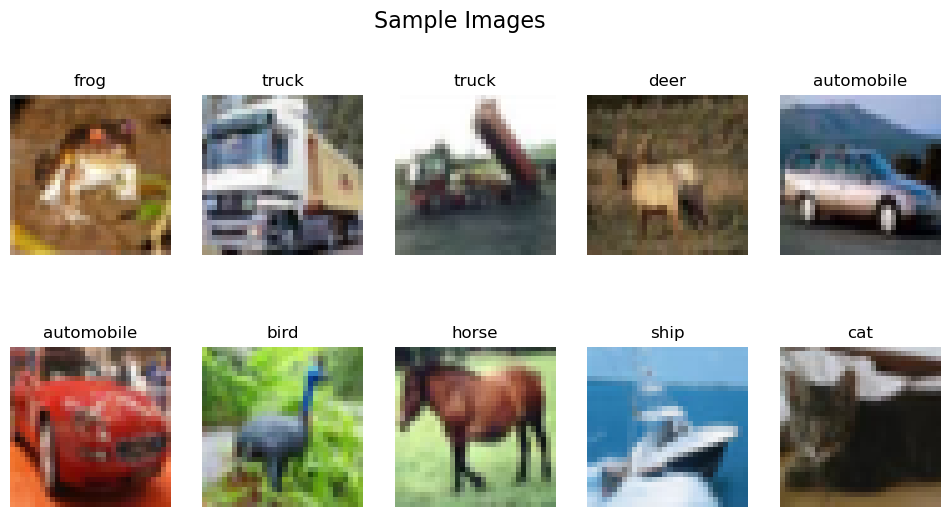

In [72]:
def reshape_images(data):
    return data.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

train_images = reshape_images(train_data)
test_images = reshape_images(test_data)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Sample Images", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(train_images[i])
    ax.set_title(label_names[train_labels[i]])
    ax.axis('off')
plt.show()

### Analyze Class Distribution

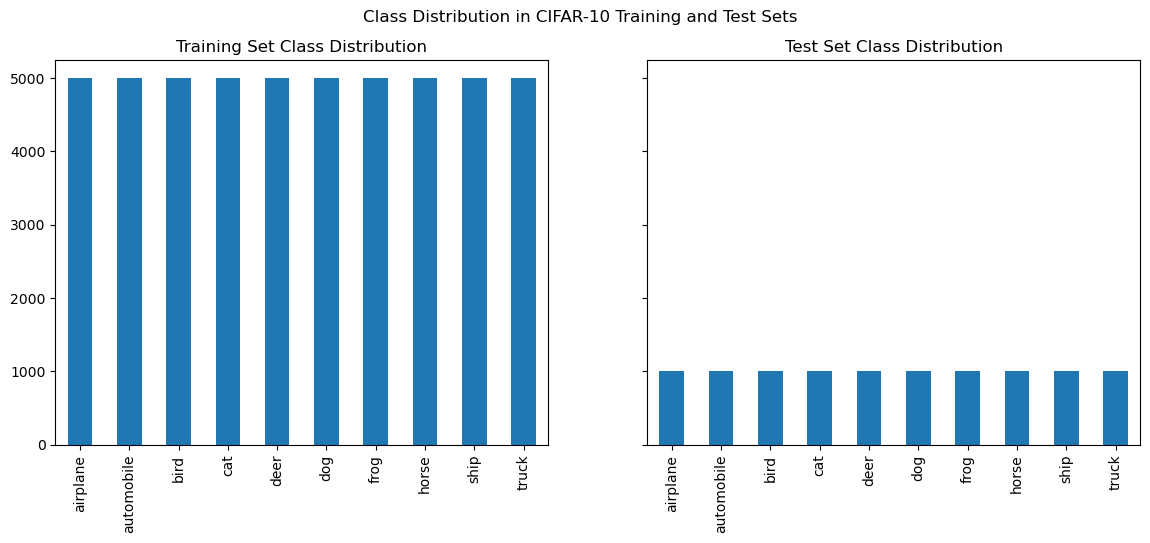

In [74]:
train_label_counts = pd.Series(train_labels).value_counts().sort_index()
test_label_counts = pd.Series(test_labels).value_counts().sort_index()

train_class_counts = train_label_counts.rename(index=dict(enumerate(label_names)))
test_class_counts = test_label_counts.rename(index=dict(enumerate(label_names)))

fig, ax = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
train_class_counts.plot(kind='bar', ax=ax[0], title="Training Set Class Distribution")
test_class_counts.plot(kind='bar', ax=ax[1], title="Test Set Class Distribution")
plt.suptitle("Class Distribution in CIFAR-10 Training and Test Sets")
plt.show()

### Compute and Display Average Images per Class

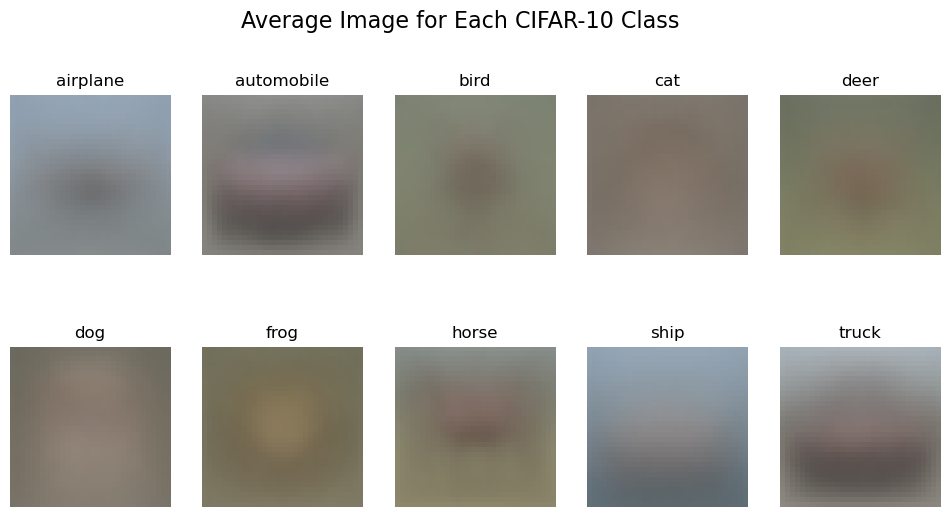

In [76]:
avg_images = []
for i in range(10):
    class_images = train_images[train_labels == i]
    avg_image = np.mean(class_images, axis=0)
    avg_images.append(avg_image)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Average Image for Each CIFAR-10 Class", fontsize=16)
for i, ax in enumerate(axes.flat):
    ax.imshow(avg_images[i].astype(np.uint8))
    ax.set_title(label_names[i])
    ax.axis('off')
plt.show()

### Image Standardization
Standardizing images by channel-wise means and standard deviations brings all pixel values onto a similar scale, making it easier for models to learn patterns. We calculate the mean and standard deviation for each channel and use these values to normalize both the training and test images.

In [83]:
channel_means = np.mean(train_images, axis=(0, 1, 2)) / 255.0
channel_stds = np.std(train_images, axis=(0, 1, 2)) / 255.0

train_images_standardized = (train_images / 255.0 - channel_means) / channel_stds
test_images_standardized = (test_images / 255.0 - channel_means) / channel_stds

print(f"Channel Means: {channel_means}")
print(f"Channel Standard Deviations: {channel_stds}")


Channel Means: [0.49139968 0.48215841 0.44653091]
Channel Standard Deviations: [0.24703223 0.24348513 0.26158784]


### Data Augmentation
Data augmentation techniques such as rotations, shifts, and horizontal flips help improve the model’s robustness by introducing variability. This step shows examples of augmented images generated from a single training image using `ImageDataGenerator`.


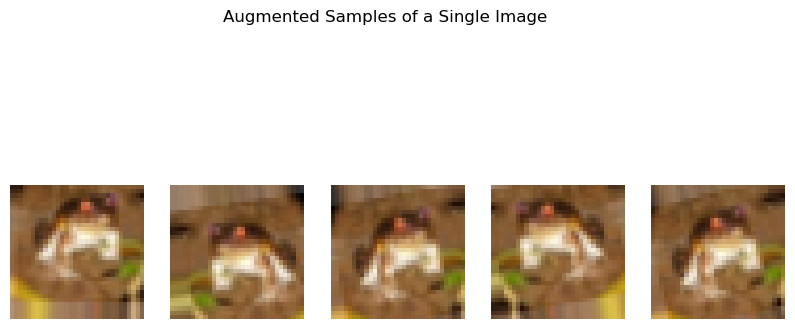

In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,      
    width_shift_range=0.1, 
    height_shift_range=0.1,
    horizontal_flip=True,  
)

sample_image = train_images[0]  
sample_image = np.expand_dims(sample_image, 0) 

plt.figure(figsize=(10, 5))
for i, batch in enumerate(datagen.flow(sample_image, batch_size=1)):
    plt.subplot(1, 5, i + 1)
    plt.imshow(batch[0].astype('uint8'))
    plt.axis('off')
    if i == 4:
        break
plt.suptitle("Augmented Samples of a Single Image")
plt.show()